## Multiclass Classification Model using a custom CNN in Tensorflow: Melanoma Detection

**Problem statement: **
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
tf.__version__

'2.8.2'

### Importing Skin Cancer Data

### Connecting to google drive

In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

### Fetching train and test data 

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### creating a code to visualize one instance of all the nine classes present in the dataset

0 vascular lesion
1 nevus
2 pigmented benign keratosis
3 melanoma
4 dermatofibroma
5 actinic keratosis
6 basal cell carcinoma
7 squamous cell carcinoma
8 seborrheic keratosis


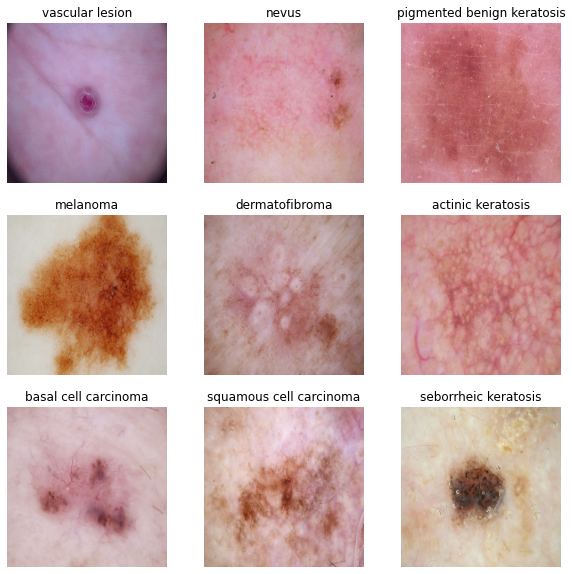

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
class_seen = []
image_count = 0
for images, labels in train_ds.take(10):
    for i in range(32):
        if class_names[labels[i]] not in class_seen:
            print(image_count, class_names[labels[i]])
            ax = plt.subplot(3, 3, image_count + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            class_seen.append(class_names[labels[i]])
            image_count += 1

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [ ]:
### choosing an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 32)        9

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 518s 2s/step - loss: 1.9345 - accuracy: 0.2734 - val_loss: 1.7039 - val_accuracy: 0.4340
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.6198 - accuracy: 0.4202 - val_loss: 1.5329 - val_accuracy: 0.4832
Epoch 3/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4584 - accuracy: 0.4860 - val_loss: 1.5139 - val_accuracy: 0.4541
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4056 - accuracy: 0.5000 - val_loss: 1.4328 - val_accuracy: 0.4922
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.4017 - accuracy: 0.5011 - val_loss: 1.5401 - val_accuracy: 0.4899
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.3275 - accuracy: 0.5206 - val_loss: 1.4502 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.2160 - accuracy: 0.5647 - val_loss: 1.3668 - val_accuracy: 0.5302
Epoch 8/20
56

### Visualizing training results

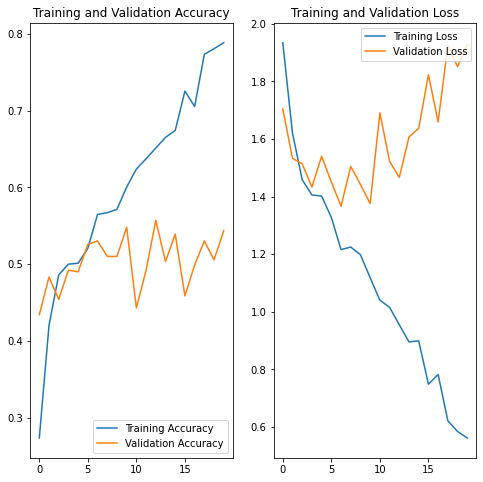

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here

Observations :-

The training accuracy is over 75% and the validation accuracy is 56.8%

Similarly, the training loss is 0.57 while the validation loss is 1.9

The above graph also shows the same trend with Training Loss continuously reduces, but the Validation Loss starts increasing after a few epochs.
We can see clearly the data is over fitting.

Data Augumentation to Resolve Overfitting:

In [ ]:
# after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

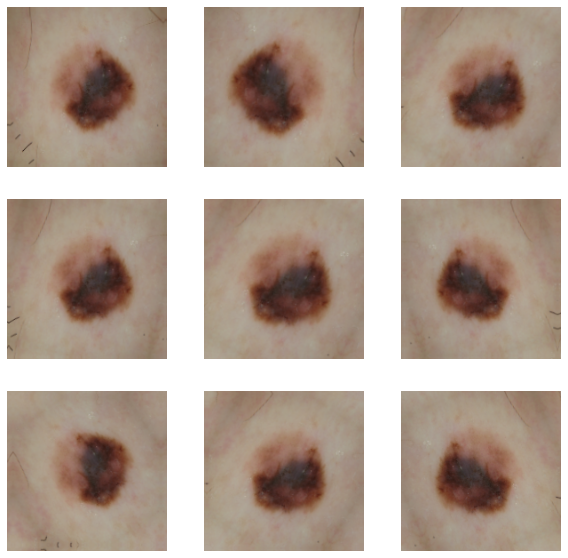

In [ ]:
# visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


### Compiling the model

In [ ]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
## training model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 155s 3s/step - loss: 1.9974 - accuracy: 0.2405 - val_loss: 1.8052 - val_accuracy: 0.3512
Epoch 2/20
56/56 [==============================] - 2s 31ms/step - loss: 1.7371 - accuracy: 0.3616 - val_loss: 1.7344 - val_accuracy: 0.3714
Epoch 3/20
56/56 [==============================] - 2s 31ms/step - loss: 1.6143 - accuracy: 0.4046 - val_loss: 1.5587 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.5837 - accuracy: 0.4358 - val_loss: 1.5805 - val_accuracy: 0.4295
Epoch 5/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4939 - accuracy: 0.4660 - val_loss: 1.5459 - val_accuracy: 0.4452
Epoch 6/20
56/56 [==============================] - 2s 31ms/step - loss: 1.4555 - accuracy: 0.4788 - val_loss: 1.5161 - val_accuracy: 0.4743
Epoch 7/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3759 - accuracy: 0.5089 - val_loss: 1.4610 - val_accuracy: 0.5145
Epoch 8/20
56

### Visualizing the results

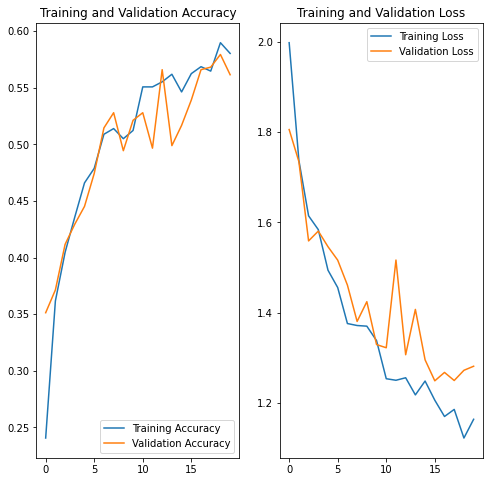

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The model is no longer overfitting as much as the previous model.

However, the training accuracy has significantly reduced to 58%.

The validation accuracy is 56%.

The above graph also shows the same trend with Training Loss and Validation Loss reducing together.

Overall, this model is better as overfitting has been reduced. However, it is still showing lower accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

                            count  percentage
pigmented benign keratosis    462        20.6
melanoma                      438        19.6
basal cell carcinoma          376        16.8
nevus                         357        15.9
squamous cell carcinoma       181         8.1
vascular lesion               139         6.2
actinic keratosis             114         5.1
dermatofibroma                 95         4.2
seborrheic keratosis           77         3.4


([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

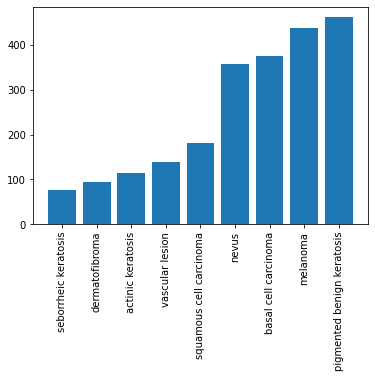

In [ ]:

class_count = {}
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    data_dir = pathlib.Path(path_to_training_dataset + i)
    image_count = len(list(data_dir.glob('*.jpg')))
    class_count[i] = image_count

df = pd.DataFrame(class_count.values(), index=class_count.keys(), columns=['count'])
df['percentage'] = round(100 * df['count']/df['count'].sum(), 1)
print(df.sort_values(by=['count'], ascending=False))

class_count = {k: v for k, v in sorted(class_count.items(), key=lambda item: item[1])}
plt.bar(class_count.keys(), height=class_count.values())
plt.xticks(rotation=90)

#### **Todo:** Write your findings here: 
- Which class has the least number of samples?

#### 'seborrheic keratosis' with 77 images (3.4%) has the least number of sample images.
#### 'dermatofibroma' (95, 4.2%), 'actinic keratosis' (114, 5.1%) and 'vascular lesion' (139, 6.2%) also have limited samples.
- Which classes dominate the data in terms proportionate number of samples?

#### 'pigmented benign keratosis' (462, 20.6%) and 'melanoma'(438, 19.6) samples dominate the dataset.
#### 'nevus'(357, 15.9%) and 'basal cell carcinoma'(376, 16.8%) also have a large proportion of samples.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE35312AE10>: 100%|██████████| 500/500 [00:21<00:00, 23.01 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE352613690>: 100%|██████████| 500/500 [00:18<00:00, 27.04 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE352652A10>: 100%|██████████| 500/500 [00:18<00:00, 27.23 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2816x2112 at 0x7FE352651FD0>: 100%|██████████| 500/500 [01:42<00:00,  4.86 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7FE35262C150>: 100%|██████████| 500/500 [01:33<00:00,  5.33 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE35255E290>: 100%|██████████| 500/500 [00:18<00:00, 27.25 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FE352603390>: 100%|██████████| 500/500 [00:45<00:00, 10.93 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE3525D7790>: 100%|██████████| 500/500 [00:18<00:00, 27.07 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FE3525E5A90>: 100%|██████████| 500/500 [00:18<00:00, 26.34 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
#path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#path_list
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
print(f'Original count of images within train/class folder: {len(path_list)}')
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
print(f'Total augmented images within train/class/output folder: {len(path_list_new)}')

Original count of images within train/class folder: 2239
Total augmented images within train/class/output folder: 4500


In [ ]:
#lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]


In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict = dict(zip(path_list, lesion_list))

In [ ]:
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

                            count  percentage
pigmented benign keratosis    962        14.3
melanoma                      938        13.9
basal cell carcinoma          876        13.0
nevus                         857        12.7
squamous cell carcinoma       681        10.1
vascular lesion               639         9.5
actinic keratosis             614         9.1
dermatofibroma                595         8.8
seborrheic keratosis          577         8.6


([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text major ticklabel objects>)

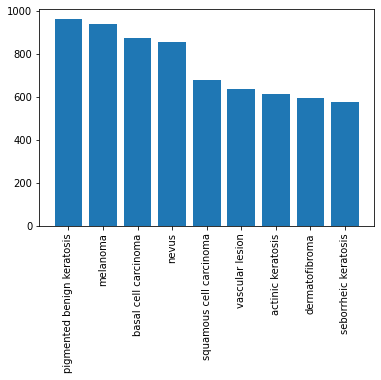

In [ ]:
class_count = dict(new_df['Label'].value_counts())

df = pd.DataFrame(class_count.values(), index=class_count.keys(), columns=['count'])
df['percentage'] = round(100 * df['count']/df['count'].sum(), 1)
print(df.sort_values(by=['count'], ascending=False))

plt.bar(class_count.keys(), height=class_count.values())
plt.xticks(rotation=90)

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.
* Data looks balenced now.

Observations :-

Classes which had very less samples:
*   seborrheic keratosis has increased from 3.4% to 8.6%
*   dermatofibroma has increased from 4.2% to 8.8%
*   actinic keratosis has increased from 5.1% to 9.1%

Classes that dominated the data:
* 'pigmented benign keratosis' has reduced from 20.6% to 14.3%
* 'melanoma' has reduced from 19.6 to 13.9%
* 'basal cell carcinoma' has reduced from 16.8% to 13%
* 'nevus' has reduced from 15.9% to 12.7%

#### Training the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width), batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### CNN model (including normalization)

In [ ]:
model = Sequential([
  data_augmentation,
#   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
#   layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
#   layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
#   layers.BatchNormalization(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
#   layers.BatchNormalization(),
#   layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 32)        9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

#### Training Model

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 29s 159ms/step - loss: 1.8967 - accuracy: 0.2613 - val_loss: 1.6192 - val_accuracy: 0.4407
Epoch 2/30
169/169 [==============================] - 29s 163ms/step - loss: 1.5896 - accuracy: 0.3884 - val_loss: 1.4462 - val_accuracy: 0.5190
Epoch 3/30
169/169 [==============================] - 33s 188ms/step - loss: 1.4498 - accuracy: 0.4392 - val_loss: 1.3858 - val_accuracy: 0.5190
Epoch 4/30
169/169 [==============================] - 28s 162ms/step - loss: 1.4012 - accuracy: 0.4598 - val_loss: 1.3600 - val_accuracy: 0.5257
Epoch 5/30
169/169 [==============================] - 27s 157ms/step - loss: 1.3237 - accuracy: 0.4935 - val_loss: 1.2479 - val_accuracy: 0.5503
Epoch 6/30
169/169 [==============================] - 26s 148ms/step - loss: 1.2817 - accuracy: 0.5059 - val_loss: 1.1574 - val_accuracy: 0.5973
Epoch 7/30
169/169 [==============================] - 27s 156ms/step - loss: 1.2264 - accuracy: 0.5373 - val_loss: 1.2629 - val_ac

#### **Todo:**  Visualize the model results

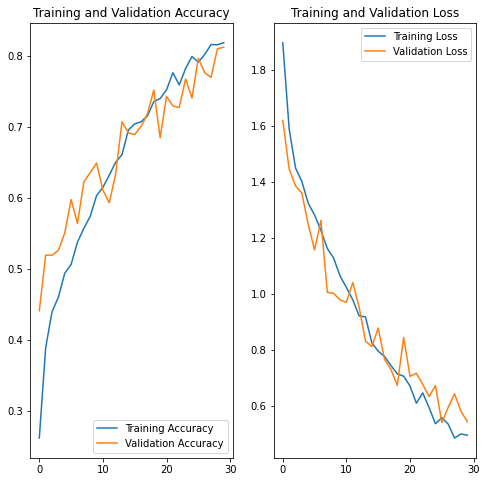

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analysis



Observations :

* The training accuracy has increased to 83% from 56%.
* The final validation accuracy has increased to 74% from 54%.

Conclusion :

* The model is not overfitting or underfitting the data.
* The results indicate that the class rebalance has helped us to improve the results.
* After class rebalance, the model is more accurate.
